# Clase Utilizada para graficar curva de aprendizaje

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras import regularizers

import lib.utils as utils
import lib.model_utils as model_utils

# Cargo datos

In [3]:
folder = './input/'
x = np.load(folder+'train_images.npy')
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder+'test_images.npy')

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1, shuffle=True)

TypeError: Invalid dimensions for image data

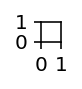

In [8]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)



import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

    
show_images(x_test[0,])

# Red neuronal básica

In [6]:
output_size = 10

# initializer = initializers.normal(mean=0, stddev=0.001)
initializer = 'normal'

# regularizer = regularizers.l2(0)
# regularizer = regularizers.l2(l2_lambda)
regularizer = regularizers.l2(0.0001)

# Creo el modelo
model = Sequential()

model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(
    1500,
    kernel_initializer=initializer, 
    bias_initializer=initializer,
    name='Hidden', 
    activation='sigmoid',
    kernel_regularizer=regularizer, 
    bias_regularizer=regularizer
))
model.add(Dense(
    output_size, 
    kernel_regularizer=regularizer, 
    bias_regularizer=regularizer,
    name='Salida')
)
model.add(Activation('softmax'))

# model.summary()

In [7]:
# Compilo el modelo
lr = 0.0001 #0.01, 0.001, 0.00001, 0.000001, 0.00000001
#lr = 0.00000001
#lr = 0.01

# optimizer = optimizers.sgd(lr=1, decay=0, momentum=0)
# optimizer = optimizers.sgd(lr=0.001, decay=0, momentum=0) 
optimizer = optimizers.adam(lr=lr)

model.compile(
    loss = 'categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

In [8]:
# Callbacks

## Callback para graficar
plot_losses = model_utils.plot_losses(
    plot_interval=1, 
    evaluate_interval=10, 
    x_val=x_valid, 
    y_val_categorical=y_val_categorical
)

## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)

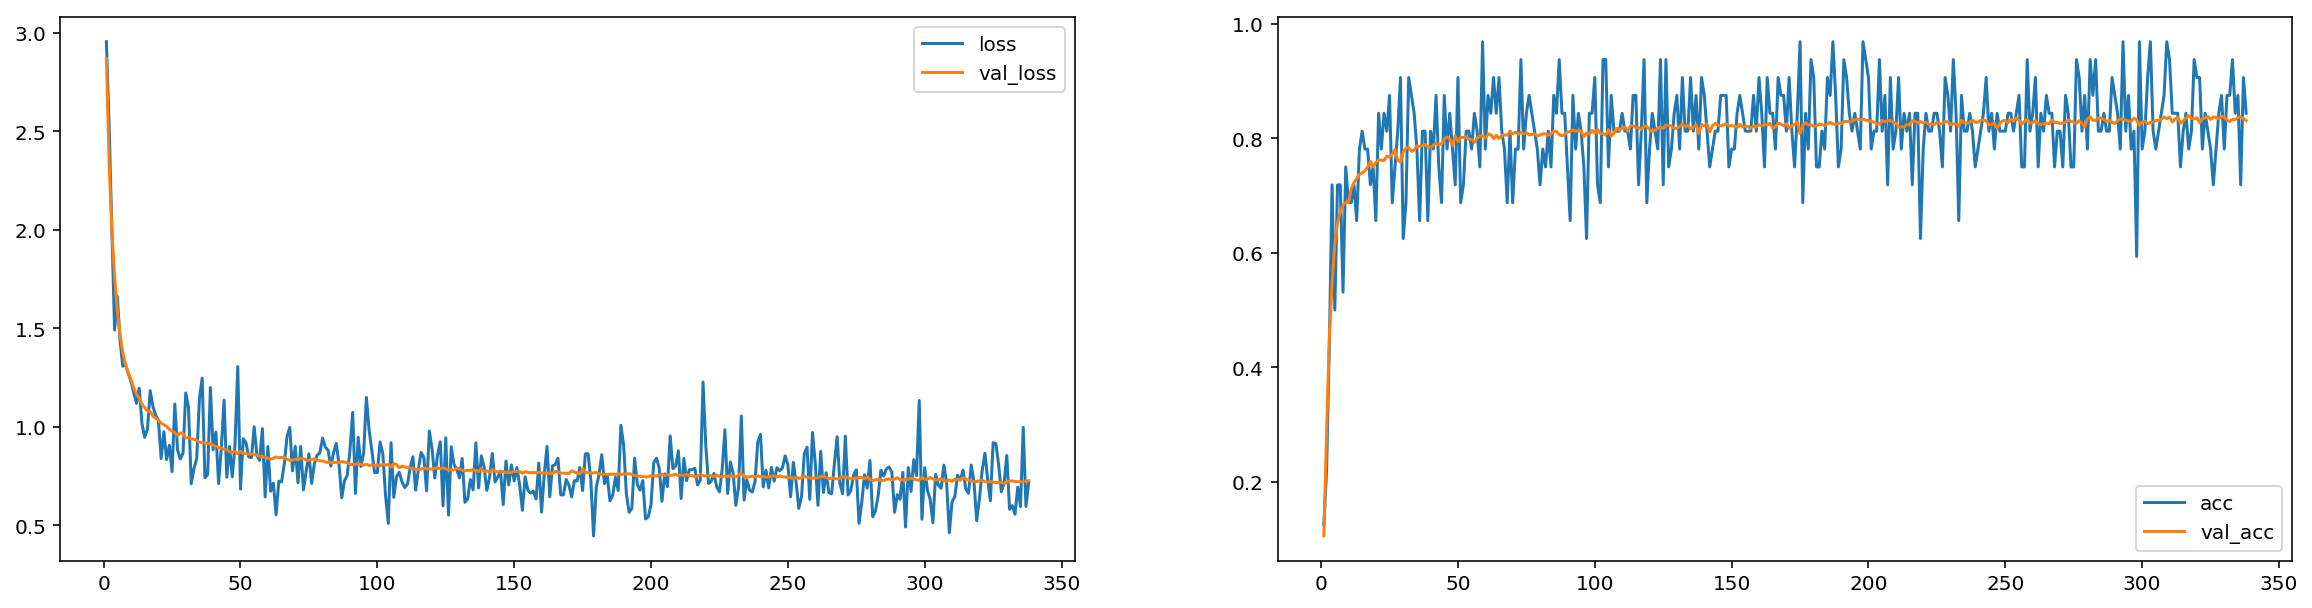


Epoch 00002: val_loss improved from 0.76279 to 0.71776, saving model to model.hdf5
Epoch 3/5
   64/54000 [..............................] - ETA: 2:35 - loss: 0.6028 - acc: 0.8594

/home/adrian/anaconda3/envs/curso/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174036). Check your callbacks.
  % delta_t_median)


 4544/54000 [=>............................] - ETA: 31s - loss: 0.7072 - acc: 0.8504

KeyboardInterrupt: 

In [9]:
epochs      = [  5,   5,  20,   10,  30,    5,  30,    3,  30,    5,  30,     3,  10]
batch_sizes = [ 32, 128, 512, 1024, 512, 1024, 512, 1024, 512, 1024, 512,  1024, 512]

assert len(epochs) == len(batch_sizes)

val_accuracies, val_losses = model_utils.fit(
    model,
    epochs=epochs,
    batch_sizes=batch_sizes, 
    train_set= (x_train, y_train_categorical), 
    validation_set=(x_valid, y_val_categorical),
    callbacks=[plot_losses, checkpointer],
    shuffle=True
)

In [ ]:
summary = utils.create_summary(
    epochs=epochs,
    lr=lr,
    optimizer=optimizer,
    batch_sizes=batch_sizes,
    val_losses=val_losses,
    val_accuracies=val_accuracies
)

In [ ]:
model.load_weights('model.hdf5')
test_labels = np.argmax(model.predict(x_test), axis = 1)
utils.save_results(summary, test_labels, utils.current_time())